In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "PAPER_IMPLEMENTATION"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preparing Data

(Resize and Crop)

fixed size input image: 224 x 224

to obtain the fixed-size images, they were randomly cropped from rescaled training images.

- **first approach:**
    
    Rescaling original training images to fixed size S, then randomly crop.
    
- **second approach:**
    
    Each training image is individually rescaled by randomly sampling S from a certain range [S_{min}, S_{max}], then randomly crops to fixed-size images.
    
    Since objects in images can be of different sizes, it is beneficial to take this into account during training. **This can also be seen as training set augmentation by scale jittering**, where a single model is trained to recognize objects over a wide range of scales.
    
    For speed reasons, they trained multi-scale models by fine-tuning all layers of a single-scale model with the same configuration, pre-trained with fixed S.

(Normalization)

Guide in Paper: Subtracting the mean RGB value, computed on the training set, from each pixel.

What I Added: Dividing the std RGB value, computed on the training set, from each pixel.

(Rotation)

What I Added: Randomly rotate the image by angle which randomly selected in the range of (-5, +5).

(Random Horizontal Flip)

What I Added: Horizontally flip the given image randomly.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import os
import numpy as np

path2data = "/content/drive/My Drive/Dataset/STL10"

if not os.path.exists(path2data):
  os.mkdir(path2data)

raw_data_transformer = transforms.Compose([transforms.ToTensor()])

raw_train_ds = datasets.STL10(path2data, "train", transform = raw_data_transformer,
                              download = True)

print(raw_train_ds.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [3]:
raw_train_ds

Dataset STL10
    Number of datapoints: 5000
    Root location: /content/drive/My Drive/Dataset/STL10
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
meanRGB = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in raw_train_ds]
stdRGB = [np.std(x.numpy(), axis = (1, 2)) for x, _ in raw_train_ds]

print(meanRGB)
print(stdRGB)

[array([0.5199615 , 0.47785485, 0.34138668], dtype=float32), array([0.54801244, 0.49918514, 0.3546922 ], dtype=float32), array([0.35330972, 0.476511  , 0.32713312], dtype=float32), array([0.28504393, 0.18103725, 0.06127664], dtype=float32), array([0.59752524, 0.53206277, 0.3785246 ], dtype=float32), array([0.29870942, 0.3082827 , 0.43114534], dtype=float32), array([0.5929543 , 0.50698954, 0.2887621 ], dtype=float32), array([0.6084938 , 0.5155935 , 0.33452052], dtype=float32), array([0.33961484, 0.32467195, 0.3026799 ], dtype=float32), array([0.22933687, 0.29132754, 0.34868008], dtype=float32), array([0.5129017 , 0.5113609 , 0.49742603], dtype=float32), array([0.49266922, 0.42515066, 0.3476988 ], dtype=float32), array([0.654462 , 0.6404829, 0.6414795], dtype=float32), array([0.5481465 , 0.56473017, 0.59070456], dtype=float32), array([0.28765833, 0.33323634, 0.2420186 ], dtype=float32), array([0.5736205, 0.4905429, 0.4090448], dtype=float32), array([0.4112643 , 0.40061444, 0.37653655], d

In [5]:
meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

print(meanR, meanG, meanB)

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [6]:
train_transformer = transforms.Compose([
    transforms.RandomResizedCrop(size = 224),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

test_transformer = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.RandomCrop(size = 224),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

train_ds = datasets.STL10(path2data, "train", transform = train_transformer,
                          download = True)

test_ds = datasets.STL10(path2data, "test", transform = test_transformer,
                          download = True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size= 0.5, random_state = 0)

indices = list(range(len(test_ds)))
y_test = [y for _, y in test_ds]

for test_index, val_index in sss.split(indices, y_test):
  print("test index : ", test_index, "val index : ", val_index)
  print(len(test_index), len(val_index))

test index :  [ 662 2827 1269 ... 2117 3274 1699] val index :  [1540 2593 2013 ... 1954 6775 7880]
4000 4000


In [8]:
from torch.utils.data import Subset

val_ds = Subset(test_ds, val_index)
test_ds = Subset(test_ds, test_index)

In [9]:
# Data Loader
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size = 256, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 256, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 256, shuffle = False)

In [10]:
for x, y in train_dl:
  print(x.shape)
  print(y.shape)
  break

for x, y in val_dl:
  print(x.shape)
  print(y.shape)
  break

for x, y in test_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([256, 3, 224, 224])
torch.Size([256])
torch.Size([256, 3, 224, 224])
torch.Size([256])
torch.Size([256, 3, 224, 224])
torch.Size([256])


### Build Model

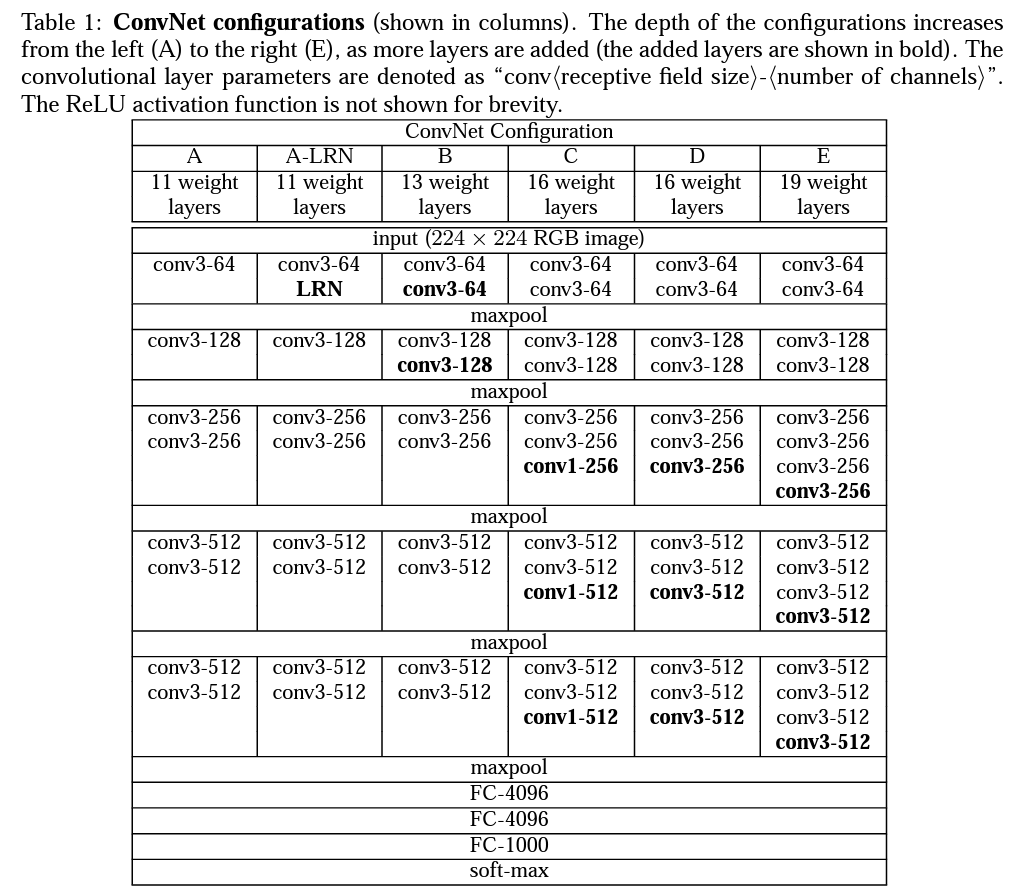

In [11]:
from torch import nn
import torch.nn.functional as F

class VGGnet(nn.Module):
  def __init__(self):
    super(VGGnet, self).__init__()
  
  def forward(self, x):
    pass
  
def __init__(self):
  super(VGGnet, self).__init__()

  self.conv1 = nn.Conv2d(3, 64, 3, 1, 1) #conv3-64
  self.conv2 = nn.Conv2d(64, 64, 3, 1, 1) #conv3-64

  self.conv3 = nn.Conv2d(64, 128, 3, 1, 1) #conv3-128
  self.conv4 = nn.Conv2d(128, 128, 3, 1, 1) #conv3-128

  self.conv5 = nn.Conv2d(128, 256, 3, 1, 1) #conv3-256
  self.conv6 = nn.Conv2d(256, 256, 3, 1, 1) #conv3-256
  self.conv7 = nn.Conv2d(256, 256, 3, 1, 1) #conv3-256

  self.conv8 = nn.Conv2d(256, 512, 3, 1, 1) #conv3-512
  self.conv9 = nn.Conv2d(512, 512, 3, 1, 1) #conv3-512
  self.conv10 = nn.Conv2d(512, 512, 3, 1, 1) #conv3-512

  self.conv11 = nn.Conv2d(512, 512, 3, 1, 1) #conv3-512
  self.conv12 = nn.Conv2d(512, 512, 3, 1, 1) #conv3-512
  self.conv13 = nn.Conv2d(512, 512, 3, 1, 1) #conv3-512
  
  self.fc1 = nn.Linear(7*7*512, 4096) #fc-4096
  self.fc2 = nn.Linear(4096, 4096) #fc-4096
  self.fc3 = nn.Linear(4096, 10) #fc-1000

  self.dropout1 = nn.Dropout(0.5)
  self.dropout2 = nn.Dropout(0.5)

VGGnet.__init__ = __init__

def forward(self, x):
  x = F.relu(self.conv1(x)) # pass conv1
  x = F.relu(self.conv2(x)) # pass conv2
  x = F.max_pool2d(x, (2, 2), 2) # max pooling

  x = F.relu(self.conv3(x)) # pass conv3
  x = F.relu(self.conv4(x)) # pass conv4
  x = F.max_pool2d(x, (2, 2), 2) # max pooling

  x = F.relu(self.conv5(x)) # pass conv5
  x = F.relu(self.conv6(x)) # pass conv6
  x = F.relu(self.conv7(x)) # pass conv7
  x = F.max_pool2d(x, (2, 2), 2) # max pooling

  x = F.relu(self.conv8(x)) # pass conv8
  x = F.relu(self.conv9(x)) # pass conv9 
  x = F.relu(self.conv10(x)) # pass conv10
  x = F.max_pool2d(x, (2, 2), 2) # max pooling

  x = F.relu(self.conv11(x)) # pass conv11
  x = F.relu(self.conv12(x)) # pass conv12
  x = F.relu(self.conv13(x)) # pass conv13
  x = F.max_pool2d(x, (2, 2), 2) # max pooling

  x = x.view(-1, 7*7*512)

  x = F.relu(self.fc1(x)) # pass fc1
  x = self.dropout1(x)
  x = F.relu(self.fc2(x)) # pass fc2
  x = self.dropout2(x)
  output = self.fc3(x) # pass fc3

  return F.log_softmax(output, dim = 1)

VGGnet.forward = forward

model = VGGnet()
print(model)

VGGnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 3)

In [12]:
import torch

print(next(model.parameters()).device)

print(torch.cuda.is_available())
print(torch.cuda.device_count())

device = torch.device("cuda:0")
model.to(device)

print(next(model.parameters()).device)

cpu
True
1
cuda:0


In [13]:
from torchsummary import summary

summary(model, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
            Conv2d-3        [-1, 128, 112, 112]          73,856
            Conv2d-4        [-1, 128, 112, 112]         147,584
            Conv2d-5          [-1, 256, 56, 56]         295,168
            Conv2d-6          [-1, 256, 56, 56]         590,080
            Conv2d-7          [-1, 256, 56, 56]         590,080
            Conv2d-8          [-1, 512, 28, 28]       1,180,160
            Conv2d-9          [-1, 512, 28, 28]       2,359,808
           Conv2d-10          [-1, 512, 28, 28]       2,359,808
           Conv2d-11          [-1, 512, 14, 14]       2,359,808
           Conv2d-12          [-1, 512, 14, 14]       2,359,808
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
           Linear-14                 [-

### Define Util functions


In [14]:
def metrics_batch(target, output):
  pred = torch.argmax(input = output, dim = 1, keepdim = True) 
  # returns the indices of the maximum value of all elements in the input tensor

  corrects = torch.eq(pred, target.view_as(pred)).sum().item()

  return corrects

In [15]:
def loss_batch(loss_func, xb, yb, yb_h, opt = None):
  loss = loss_func(yb_h, yb)

  metric_b = metrics_batch(yb, yb_h)
  # the number of corrects

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss.item(), metric_b

In [16]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check = False, opt = None):
  loss = 0.0
  metric = 0.0 # correct prediction의 수
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb = xb.type(torch.float).to(device)
    yb = yb.to(device)

    # obtain model output
    yb_h = model(xb)

    loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
    loss += loss_b

    if metric_b is not None:
      metric += metric_b
    
    if sanity_check is True:
      break

    del xb
    del yb 
   
  loss /= len_data
  metric /= len_data
  return loss, metric

In [17]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [18]:
def train_val(model, params):
  num_epochs = params["num_epochs"]
  loss_func = params["loss_func"]
  opt = params["optimizer"]
  train_dl = params["train_dl"]
  val_dl = params["val_dl"]
  sanity_check = params["sanity_check"]
  lr_scheduler = params["lr_scheduler"]
  path2weights = params["path2weights"]

  loss_history = {
      "train" : [],
      "val" : [],
  }

  metric_history = {
      "train" : [],
      "val" : [],
  }

  # define variables to store the best model parameters
  best_models_wts = copy.deepcopy(model.state_dict())
  best_loss = float("inf")

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print("Epoch {}/{}, current lr = {}".format(epoch, num_epochs - 1, current_lr))
    model.train()
    
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

    loss_history["train"].append(train_loss)
    metric_history["train"].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
      loss_history["val"].append(val_loss)
      metric_history["val"].append(val_metric)

    if val_loss <best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights")
      
    lr_scheduler.step(val_loss)

    print("train loss : %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss, val_loss, 100*val_metric))
    print("-"*10)

    # re define train_ds -> for getting other configuration of training dataset
    train_ds = datasets.STL10(path2data, split = 'train', transform = train_transformer, download = False)
    train_dl = DataLoader(train_ds, batch_size = 256, shuffle = True)

    
  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

### Training

In [19]:
import copy
import matplotlib.pyplot as plt
from torch import optim

loss_func = nn.CrossEntropyLoss(reduction = "sum")

opt = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-6)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',  factor = 0.1,patience = 5)

params_train = {
    "num_epochs" : 100,
    "loss_func" : loss_func,
    "optimizer" : opt,
    "train_dl" : train_dl,
    "val_dl" : val_dl,
    "sanity_check" : False,
    "lr_scheduler"  :lr_scheduler,
    "path2weights" : "/content/drive/MyDrive/PAPER_IMPLEMENTATION/Computer_Vision/Very Deep Convolutional Networks for Large Scale Image Recognition (2015)/models/model_without_reg.pt",
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr = 0.0001
Copied best model weights
train loss : 2.303454, dev loss: 2.302563, accuracy: 10.00
----------
Epoch 1/99, current lr = 0.0001
Copied best model weights
train loss : 2.297030, dev loss: 2.294794, accuracy: 18.73
----------
Epoch 2/99, current lr = 0.0001
Copied best model weights
train loss : 2.235812, dev loss: 2.231132, accuracy: 15.62
----------
Epoch 3/99, current lr = 0.0001
Copied best model weights
train loss : 2.140033, dev loss: 1.974090, accuracy: 26.35
----------
Epoch 4/99, current lr = 0.0001
Copied best model weights
train loss : 2.047684, dev loss: 1.930078, accuracy: 29.60
----------
Epoch 5/99, current lr = 0.0001
Copied best model weights
train loss : 1.971276, dev loss: 1.824197, accuracy: 31.67
----------
Epoch 6/99, current lr = 0.0001
Copied best model weights
train loss : 1.930189, dev loss: 1.814059, accuracy: 31.77
----------
Epoch 7/99, current lr = 0.0001
Copied best model weights
train loss : 1.912590, dev loss: 1.759182, acc

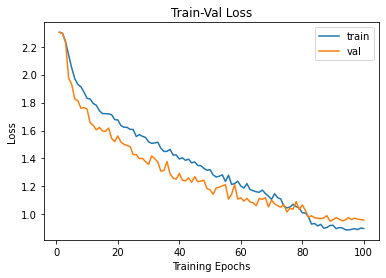

In [20]:
num_epochs = params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs + 1), loss_hist["train"], label = "train")
plt.plot(range(1, num_epochs + 1), loss_hist["val"], label = "val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

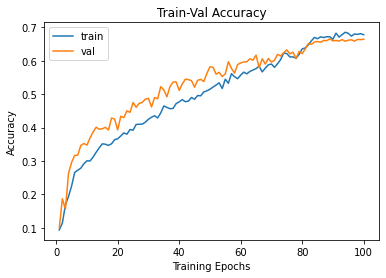

In [21]:
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs + 1), metric_hist["train"], label = "train")
plt.plot(range(1, num_epochs + 1), metric_hist["val"], label = "val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()